In [1]:
# Load Libraries

import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from numpy import linalg as la
from random import sample

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV


import pandas as pd

# Setting Constants

TI_limit = 25; 
TR = 7500; # (7.5 sesconds) T1 affects next slive

In [10]:
# Loading Confusion Matrix

conf_mat = np.load('conf_mat_all_params.npy')
conf_mat.shape

(3, 3, 5)

In [11]:
# Normalising Matrices

def normalise_mat(C):
    C_n = C / C.astype(np.float).sum(axis=1, keepdims=True)
    # Correct, checked using: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    # Found at: https://stackoverflow.com/questions/20927368/python-how-to-normalize-a-confusion-matrix
    
    return C_n

conf_mat_n = np.zeros((3,3,5))

conf_mat_n[:,:,0] = normalise_mat(conf_mat[:,:,0])
conf_mat_n[:,:,1] = normalise_mat(conf_mat[:,:,1])
conf_mat_n[:,:,2] = normalise_mat(conf_mat[:,:,2])
conf_mat_n[:,:,3] = normalise_mat(conf_mat[:,:,3])
conf_mat_n[:,:,4] = normalise_mat(conf_mat[:,:,4])

In [12]:
# Calculating average confusion matrix
avg_conf = np.mean( np.array([ conf_mat_n[:,:,0],conf_mat_n[:,:,1],conf_mat_n[:,:,2], conf_mat_n[:,:,3], conf_mat_n[:,:,4] ]), axis=0 )
std_conf = np.std(np.array([ conf_mat_n[:,:,0],conf_mat_n[:,:,1],conf_mat_n[:,:,2], conf_mat_n[:,:,3], conf_mat_n[:,:,4] ]), axis=0 )
avg_conf_train = np.mean( np.array([ conf_mat_n[:,:,0],conf_mat_n[:,:,1],conf_mat_n[:,:,2]]), axis=0 )
avg_conf_test = np.mean( np.array([conf_mat_n[:,:,3], conf_mat_n[:,:,4] ]), axis=0 )

In [13]:
avg_conf

array([[9.91908702e-01, 8.09129808e-03, 0.00000000e+00],
       [6.18978259e-03, 9.79143781e-01, 1.46664368e-02],
       [2.54129606e-04, 4.70467591e-02, 9.52699111e-01]])

In [14]:
std_conf

array([[0.00983889, 0.00983889, 0.        ],
       [0.00388328, 0.01814481, 0.01618224],
       [0.00050826, 0.0344231 , 0.03410621]])

In [15]:
# Calculating accuracy 

avg_acc = np.sum(np.diag(avg_conf))/np.sum(np.sum(avg_conf))
avg_acc_train = np.sum(np.diag(avg_conf_train))/np.sum(np.sum(avg_conf_train))
avg_acc_test = np.sum(np.diag(avg_conf_test))/np.sum(np.sum(avg_conf_test))

acc = np.zeros((5))

for i in range (5):
    acc[i] =  np.sum(np.diag(conf_mat_n[:,:,i]))/np.sum(np.sum(conf_mat_n[:,:,i]))

In [16]:
avg_acc

print('All:', avg_acc)
print('Test:', avg_acc_test)
print('Train:', avg_acc_train)

All: 0.974583864602415
Test: 0.950514178930696
Train: 0.9906303217168947


In [17]:
acc

array([0.98915448, 0.98650194, 0.99623455, 0.95811024, 0.94291811])

In [25]:
std_acc = np.std(acc)
std_acc_train = np.std(acc[0:3])
std_acc_test = np.std(acc[3:5])

In [30]:
print('All:', std_acc)
print('Test:', std_acc_test)
print('Train:', std_acc_train)

All: 0.02048021125071547
Test: 0.007596064991552631
Train: 0.004108079973526578


In [11]:
def load_res(file_name):
    # Loading in Image

    img_nifti = nib.load(file_name)

    img =img_nifti.dataobj[:,:,:,:]
    
    classif = img[:,:,:,0]
    segment = img[:,:,:,1:4]

    return classif, segment

In [12]:
# Loading in Results

class_S1, seg_S1 = load_res('all_param_rf_S1.nii')
class_S2, seg_S2 = load_res('all_param_rf_S2.nii')
class_S3, seg_S3 = load_res('all_param_rf_S3.nii')
class_S4, seg_S4 = load_res('all_param_rf_S4.nii')
class_S5, seg_S5 = load_res('all_param_rf_S5.nii')

In [13]:
# Checking Shape

print('class shape: ', np.shape(class_S1))
print('seg shape: ', np.shape(seg_S1))

class shape:  (77, 92, 56)
seg shape:  (77, 92, 56, 3)


In [14]:
# Combining into a List
class_list = [class_S1, class_S2, class_S3, class_S4, class_S5] 
seg_list = [seg_S1, seg_S2, seg_S3, seg_S4, seg_S5 ]

In [15]:
# Saving Lists
np.save('class_list_all.npy', class_list, allow_pickle = True)
np.save('seg_list_all.npy', seg_list, allow_pickle = True)

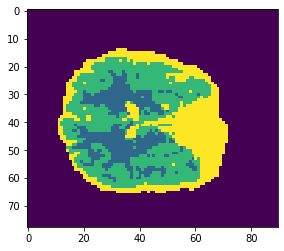

In [16]:
plt.imshow(class_list[4][:,:,33])

In [17]:
# Plotting everything for slice 33

def plotting_all_results(class_S, seg_S, z, n=5):
    fig = plt.gcf()
    fig.set_size_inches(20,20)

    for i in range (0,n):  
        plt.subplot(n, 4, 1+4*i)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(class_S[i][:,:,z])
        plt.subplot(n, 4, 2+4*i)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(seg_S[i][:,:,z,0])
        plt.subplot(n, 4, 3+4*i)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(seg_S[i][:,:,z,1])
        plt.xticks([])
        plt.yticks([])
        plt.subplot(n, 4, 4+4*i)
        plt.imshow(seg_S[i][:,:,z,2])
        plt.xticks([])
        plt.yticks([])
    plt.subplots_adjust(wspace=0, hspace=0.05)
    

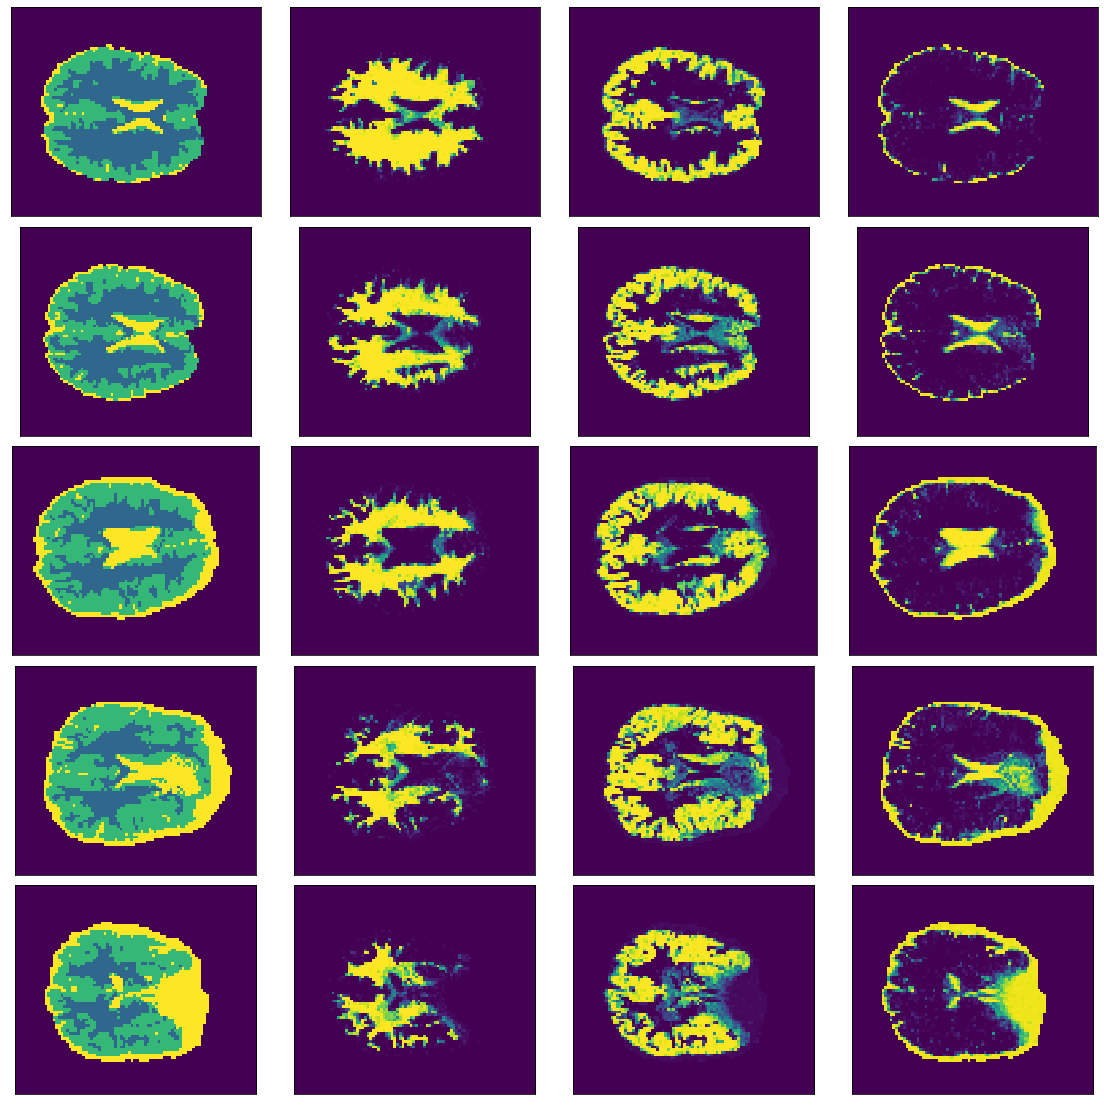

In [18]:
plotting_all_results(class_list, seg_list, 33)

<h2> Feature Importances </h2> 

In [8]:
feature_imp = np.loadtxt('all_params_feature_imp.txt')

In [9]:
feature_imp.shape

(2, 1296)

In [10]:
max(feature_imp[1,:])

0.35398967954904875

Text(0, 0.5, 'Feature Importance')

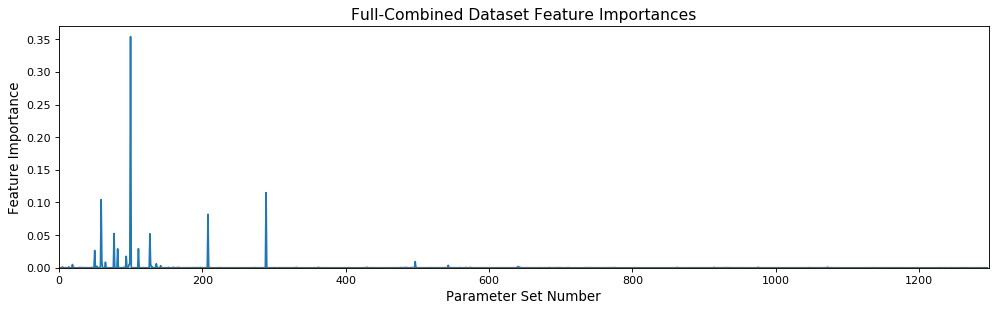

In [11]:
from matplotlib.pyplot import figure 
figure(num=None, figsize=(15, 4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(feature_imp[1,:])
plt.ylim([0,0.37])
plt.xlim([0,1297])
plt.title('Full-Combined Dataset Feature Importances', fontsize=14)
plt.xlabel('Parameter Set Number', fontsize=12)
plt.ylabel('Feature Importance', fontsize=12)

In [12]:
most_imp = feature_imp[:,feature_imp[1,:]>0.02]

In [13]:
most_imp.shape

(2, 9)

Text(0, 0.5, 'Feature Importance')

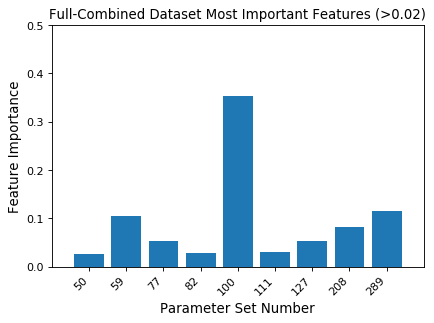

In [14]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(6, 4), dpi=80, facecolor='w', edgecolor='k')
x = np.arange(9)
plt.ylim([0,0.5])
plt.xlim([-1,9])
plt.bar(x, most_imp[1,:])
plt.xticks(x, most_imp[0,:].astype(int), rotation=45, ha="right")
plt.title('Full-Combined Dataset Most Important Features (>0.02)', fontsize=12)
plt.xlabel('Parameter Set Number', fontsize=12)
plt.ylabel('Feature Importance', fontsize=12)

In [39]:
# Setting Constants

TI_limit = 25; 
TR = 7500; # (7.5 sesconds) T1 affects next slive

# Importing Parameters

p = np.loadtxt('parameters_new.txt')
p.shape

param = np.zeros([1344,6])
param = p.copy()
# Switching first two columns as:
# [x y z] --> [y -x z] (scanner to measurement coordinate system)
param[:, 0], param[:, 1] = p[:, 1], p[:, 0].copy()
param[:,1] = -param[:,1]

b = p[:,3]
TI = p[:,4]
TE = p[:,5]

# Filter based on TI fulfilling condition
vals = TI>TI_limit
vals2 = TI>= TI_limit
indices = np.where(TI>TI_limit)
indices2 = np.where(TI>=TI_limit)
b0idx = np.where(b==0)   

TI=TI[indices]
TE=TE[indices]
param=param[indices]
b=b[indices]

In [58]:
param[362,:]

array([8.3748e-02, 1.4023e-01, 9.8657e-01, 0.0000e+00, 5.2987e+02,
       8.0000e+01])

In [44]:
np.array(indices).shape

(1, 1296)

In [45]:
np.array(indices2).shape

(1, 1296)